In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud


In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jdanz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jdanz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jdanz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Entendimiento del negocio. 

Se desea construir un modelo de aprendizaje automático supervisado para una posterior implementación en un chatbot

# Entendimiento de los Datos 

In [3]:
# Cargamos los datos. 
datatxt = pd.read_csv('../Datos/Dataset_Prueba.csv', encoding='utf-8', sep=',')

In [4]:
datatxt.head()

,Tipo,Descripción,Respuesta
0,Petición,Solicito restablecer mi contraseña.,Se ha enviado un enlace de restablecimiento al...
1,Queja,No recibí soporte técnico en el horario acordado.,"Lamentamos el inconveniente, estamos investiga..."
2,Reclamo,El equipo entregado no corresponde al solicitado.,"Por favor, envíe fotografías del equipo recibi..."
3,Petición,Necesito información sobre las políticas de pr...,Puede consultar nuestras políticas en el sigui...
4,Queja,El sistema presenta errores frecuentes al inic...,Estamos revisando el problema y le notificarem...


In [5]:
datatxt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Tipo         6 non-null      object
 1   Descripción  6 non-null      object
 2   Respuesta    6 non-null      object
dtypes: object(3)
memory usage: 276.0+ bytes


In [6]:
# Exploración básica del dataset
print(f"Forma del dataset: {datatxt.shape}")
print(f"Primeras 5 filas:")
print(datatxt.head())

# Verificar valores nulos
print(f"Valores nulos: {datatxt.isnull().sum().sum()}")

Forma del dataset: (6, 3)
Primeras 5 filas:
       Tipo                                        Descripción  \
0  Petición                Solicito restablecer mi contraseña.   
1     Queja  No recibí soporte técnico en el horario acordado.   
2   Reclamo  El equipo entregado no corresponde al solicitado.   
3  Petición  Necesito información sobre las políticas de pr...   
4     Queja  El sistema presenta errores frecuentes al inic...   

                                           Respuesta  
0  Se ha enviado un enlace de restablecimiento al...  
1  Lamentamos el inconveniente, estamos investiga...  
2  Por favor, envíe fotografías del equipo recibi...  
3  Puede consultar nuestras políticas en el sigui...  
4  Estamos revisando el problema y le notificarem...  
Valores nulos: 0


In [7]:
# Cantidad de palabras 
print(f"Cantidad de palabras: {datatxt['Tipo'].str.split().str.len().sum()}")
# Cantidad de palabras por fila
print(f"Cantidad de palabras por fila: {datatxt['Tipo'].str.split().str.len().mean()}")
# Cantidad de filas
print(f"Cantidad de filas: {datatxt.shape[0]}")
# Cantidad de columnas
print(f"Cantidad de columnas: {datatxt.shape[1]}")

Cantidad de palabras: 6
Cantidad de palabras por fila: 1.0
Cantidad de filas: 6
Cantidad de columnas: 3


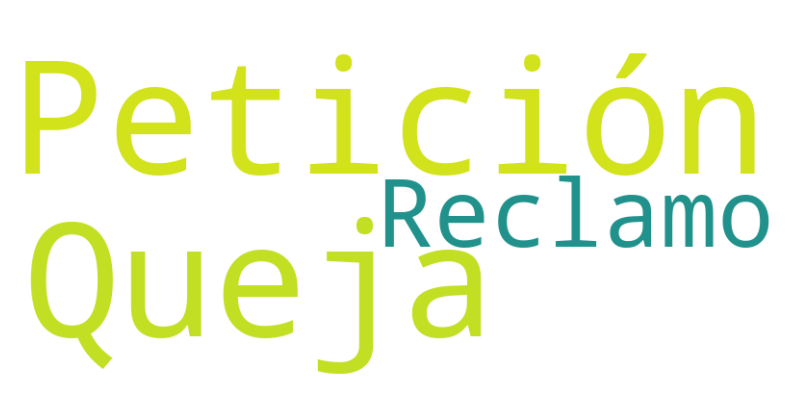

In [8]:
# Nube de palabras

def plot_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
text = ' '.join(datatxt['Tipo'].astype(str))
plot_wordcloud(text)

# Preprocesamiento de los datos 

In [9]:
datatxt_copy = datatxt.copy()

In [10]:
# Procesamiento de texto
def preprocess_text(text):
    # Convertir a minúsculas
    text = text.lower()
    # Tokenización
    tokens = word_tokenize(text)
    # Eliminar puntuación
    tokens = [word for word in tokens if word.isalpha()]
    # Eliminar stopwords
    stop_words = set(stopwords.words('spanish'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lematización
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Aplicar el procesamiento de texto a la columna 'Tipo'
datatxt_copy['TextoLimpio'] = datatxt_copy['Tipo'].apply(preprocess_text)


# Guardar el dataset procesado
datatxt_copy.to_csv('../Datos/Dataset_Procesado.csv', index=False, encoding='utf-8')

# Modelado

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

# Definir variables para Machine Learning
X = datatxt_copy["TextoLimpio"]  # Texto limpio como entrada
y = datatxt_copy["Tipo"]  # Categoría como etiqueta

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear un pipeline con TF-IDF y SVM
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        min_df=2,               # Ignora términos que aparecen en menos de 2 documentos
        max_df=0.95,            # Ignora términos que aparecen en más del 95% de los documentos
        sublinear_tf=True,      # Aplica escalado logarítmico al TF
        use_idf=True,           # Usa IDF
        ngram_range=(1, 2)      # Considera unigramas y bigramas
    )),
    ('svm', SVC(
        C=10,                   # Parámetro de regularización
        kernel='linear',        # Kernel lineal
        gamma='scale',          # Escala automática de gamma
        probability=True        # Habilitar probabilidades
    ))
])

# Entrenar el modelo
print("Entrenando el modelo SVM...")
pipeline.fit(X_train, y_train)

Entrenando el modelo SVM...


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 2),
                                 sublinear_tf=True)),
                ('svm', SVC(C=10, kernel='linear', probability=True))])

# Validación

In [14]:
# Evaluar el modelo
y_pred = pipeline.predict(X_test)
print("Exactitud del modelo:", accuracy_score(y_test, y_pred))
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))

Exactitud del modelo: 0.5
Reporte de clasificación:
              precision    recall  f1-score   support

    Petición       0.00      0.00      0.00         1
       Queja       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



c:\Users\jdanz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jdanz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jdanz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [ ]:
# Guardar el modelo entrenado
import joblib
joblib.dump(pipeline, "modelo_svm.pkl")
print("Modelo guardado en 'modelo_svm.pkl'")